In [1]:
pip install vit_pytorch linformer

In [2]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT

Data Loading Process

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

# importing modules
import urllib.request
from PIL import Image
import requests
data = pd.read_csv(
    "/content/drive/MyDrive/GBooksAPI_JSONtoPandas_withImages_20210524 (3).csv",
    sep="\t", header=0)
#data = data.to_numpy()
data.head()


,title,authors,language,description,previewLink,smallThumbnail,bigThumbnail
0,Princess Poppy: The Big Mix Up,['Janey Louise Jones'],en,A brand-new story in the best-selling Princess...,http://books.google.de/books?id=WY6VX4O2_7UC&p...,http://books.google.com/books/content?id=WY6VX...,http://books.google.com/books/content?id=WY6VX...
1,Einfach zeichnen! Step by Step,NOT_FOUND,de,NOT_FOUND,http://books.google.de/books?id=d2nlzQEACAAJ&d...,NOT_FOUND,NOT_FOUND
2,Red Queen,['Victoria Aveyard'],en,The first novel in the #1 bestselling RED QUEE...,http://books.google.de/books?id=EPO9BQAAQBAJ&p...,http://books.google.com/books/content?id=EPO9B...,http://books.google.com/books/content?id=EPO9B...
3,Meine Kindergartenfreunde,['Bianka Nadja Goylmonil'],de,Ein wunderschönes Freundebuch zur Erinnerung a...,http://books.google.de/books?id=9EUDzgEACAAJ&d...,NOT_FOUND,NOT_FOUND
4,Ewig geliebt,['J. R. Ward'],de,Rhage und Mary sind Geliebte und Seelenverwand...,http://books.google.de/books?id=O4c2DAAAQBAJ&p...,http://books.google.com/books/content?id=O4c2D...,http://books.google.com/books/content?id=O4c2D...


In [5]:
print(len(data))
data = data[data['bigThumbnail'] != "NOT_FOUND"]
print(len(data))

72217
67320


In [6]:
items=pd.read_csv("//content/drive/MyDrive/items.csv", sep="|")
items.isna().sum()

itemID           0
title            0
author        3240
publisher        9
main topic     258
subtopics        1
dtype: int64

In [7]:
items.head()

,itemID,title,author,publisher,main topic,subtopics
0,21310,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH]
1,73018,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]"
2,19194,Red Queen 1,Victoria Aveyard,Orion Publishing Group,YFH,"[5AP,FBA]"
3,40250,Meine Kindergarten-Freunde (Pirat),NaN,Ars Edition GmbH,YB,"[5AC,5AD,YBG,YBL,YF]"
4,46107,Mein großes Schablonen-Buch - Wilde Tiere,Elizabeth Golding,Edition Michael Fischer,WFTM,"[WD,WFTM,YBG,YBL,YBLD,YBLN1]"


In [8]:
len(items)

78030

In [9]:
items['main topic'] = items['main topic'].fillna("no_main_topic")
items.isna().sum()

itemID           0
title            0
author        3240
publisher        9
main topic       0
subtopics        1
dtype: int64

In [10]:
items = items.drop(['itemID', 'author',	'publisher', 'subtopics'], axis=1)
items.head()

,title,main topic
0,Princess Poppy: The Big Mix Up,YFB
1,Einfach zeichnen! Step by Step,AGZ
2,Red Queen 1,YFH
3,Meine Kindergarten-Freunde (Pirat),YB
4,Mein großes Schablonen-Buch - Wilde Tiere,WFTM


In [11]:
data = data.drop(['authors',	'language',	'description',	'previewLink',	'smallThumbnail'], axis=1)
data.head()

,title,bigThumbnail
0,Princess Poppy: The Big Mix Up,http://books.google.com/books/content?id=WY6VX...
2,Red Queen,http://books.google.com/books/content?id=EPO9B...
4,Ewig geliebt,http://books.google.com/books/content?id=O4c2D...
5,Meine Sticker-Tiere,http://books.google.com/books/content?id=bSM9t...
6,Unsterblich - Tor der Dämmerung,http://books.google.com/books/content?id=sskVj...


In [12]:
data = data.drop_duplicates(subset='title', keep="first")
items = items.drop_duplicates(subset='title', keep="first")


In [13]:
joined_dfs = items.merge(data, how='inner', on='title')
print(len(joined_dfs))
joined_dfs.head()

42458


,title,main topic,bigThumbnail
0,Princess Poppy: The Big Mix Up,YFB,http://books.google.com/books/content?id=WY6VX...
1,Ewig geliebt,FMR,http://books.google.com/books/content?id=O4c2D...
2,Meine Sticker-Tiere,YBG,http://books.google.com/books/content?id=bSM9t...
3,Unsterblich 01 - Tor der Dämmerung,YFE,http://books.google.com/books/content?id=t1-vN...
4,Pedro und die Bettler von Cartagena,YFB,http://books.google.com/books/content?id=1wuYS...


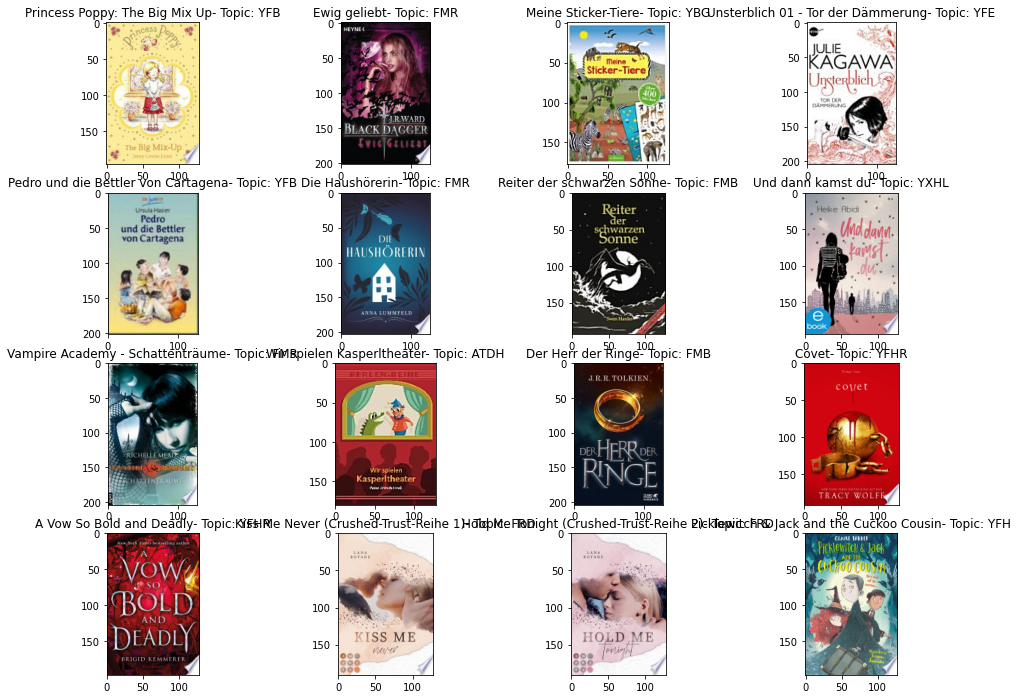

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
list_of_links = joined_dfs["bigThumbnail"]
list_of_harries = joined_dfs["bigThumbnail"]
for idx, ax in enumerate(axes.ravel()):

    im = Image.open(requests.get(list(joined_dfs["bigThumbnail"])[idx], stream=True).raw)
    ax.set_title(list(joined_dfs["title"])[idx] + "- Topic: " + list(joined_dfs["main topic"])[idx])
    ax.imshow(im)


In [15]:
print("Different Main Topics:", len(joined_dfs.set_index(["main topic", "title"]).count(level="main topic")))
joined_dfs.set_index(["main topic", "title"]).count(level="main topic")

Different Main Topics: 536


,bigThumbnail
main topic,
AB,2
AFF,1
AFH,1
AFKB,1
AG,2
...,...
YXZW,32
YZ,1
YZG,8


In [16]:
# Creat image list
list_of_images = joined_dfs['bigThumbnail'].tolist()
print("Number of Images:", len(list_of_images))

Number of Images: 42458


In [17]:
# Add labels to the list
labels = [topic[0] for topic in joined_dfs['main topic']]
labels = list(labels)

In [18]:
print("Different Main Topics:", len(set(labels)))
#joined_dfs.set_index(["main topic", "title"]).count(level="main topic")
pd.DataFrame(labels,columns=['main topic'])['main topic'].value_counts()

Different Main Topics: 21


Y    24978
F    16190
X      394
D      254
V      168
W      107
n       99
J       90
Q       42
A       40
N       36
U       11
S       11
M        8
C        7
T        7
G        6
R        5
P        3
K        1
L        1
Name: main topic, dtype: int64

Dowload images

In [21]:
from pathlib import Path
pathlist = Path("/content/drive/MyDrive/images").rglob('*.png')
done= len(list(pathlist))
print(done)
print(len(joined_dfs))

42405
42458


In [ ]:
for id in range(done,len(joined_dfs)):
    response = requests.get(list_of_images[id])

    file = open("/content/drive/MyDrive/images/" + str(id) + "__" + labels[id] +".png", "wb")
    file.write(response.content)
    file.close()

In [22]:
from pathlib import Path
pathlist = Path("/content/drive/MyDrive/images").rglob('*.png')
image_paths = []
for path in pathlist:
  image_paths.append(str(path))
len(image_paths)

42405

In [23]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [24]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [25]:
device = 'cuda'

In [26]:
# Split in Training, Validation and Test
train_list, valid_list = train_test_split(image_paths, test_size=0.1,random_state=seed)
#train_list, valid_list = train_test_split(train_list, test_size=0.2, random_state=seed)

In [27]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
#print(f"Test Data: {len(test_list)}")

Train Data: 38164
Validation Data: 4241


Image Augumentation

In [28]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

Loading Datasets


In [29]:
unique_labels = list(set(labels))
label_dictionary = dict(zip(unique_labels, range(0,len(unique_labels))))
label_dictionary

{'A': 16,
 'C': 17,
 'D': 6,
 'F': 15,
 'G': 20,
 'J': 9,
 'K': 2,
 'L': 8,
 'M': 4,
 'N': 1,
 'P': 0,
 'Q': 5,
 'R': 11,
 'S': 7,
 'T': 10,
 'U': 14,
 'V': 3,
 'W': 18,
 'X': 19,
 'Y': 12,
 'n': 13}

In [30]:
class CoverDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        #print(img_transformed)

        label_word = self.file_list[idx].split("__")[-1].split('.')[0][0]
        label = label_dictionary[label_word]

        return img_transformed, label

In [31]:
train_data = CoverDataset(train_list, transform=train_transforms)
valid_data = CoverDataset(valid_list, transform=test_transforms)
#test_data = CoverDataset(test_list, transform=test_transforms)

In [30]:
for i in range(0,len(train_data)):
    if train_data.__getitem__(i)[0].shape[0] != 3:
      print(i, train_data.__getitem__(i)[0].shape)
    


399 torch.Size([1, 224, 224])
553 torch.Size([1, 224, 224])
1257 torch.Size([1, 224, 224])
1303 torch.Size([1, 224, 224])
1705 torch.Size([1, 224, 224])
2006 torch.Size([1, 224, 224])
2088 torch.Size([1, 224, 224])
2370 torch.Size([1, 224, 224])
4248 torch.Size([1, 224, 224])
4331 torch.Size([1, 224, 224])
6750 torch.Size([1, 224, 224])
7697 torch.Size([1, 224, 224])
10001 torch.Size([1, 224, 224])
10234 torch.Size([1, 224, 224])
11849 torch.Size([1, 224, 224])
12981 torch.Size([1, 224, 224])
13888 torch.Size([1, 224, 224])
13987 torch.Size([1, 224, 224])
14017 torch.Size([1, 224, 224])
14353 torch.Size([1, 224, 224])
15095 torch.Size([1, 224, 224])
15374 torch.Size([1, 224, 224])
15422 torch.Size([1, 224, 224])
16153 torch.Size([1, 224, 224])
16276 torch.Size([1, 224, 224])
18429 torch.Size([1, 224, 224])
19938 torch.Size([1, 224, 224])
20503 torch.Size([1, 224, 224])
20505 torch.Size([1, 224, 224])
21127 torch.Size([1, 224, 224])
21225 torch.Size([1, 224, 224])
21474 torch.Size([1, 2

In [40]:
for i in range(0,len(valid_data)):
    if valid_data.__getitem__(i)[0].shape[0] != 3:
      print(i, valid_data.__getitem__(i)[0].shape)

2359 torch.Size([1, 224, 224])
2409 torch.Size([1, 224, 224])


NameError: ignored

In [32]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [33]:
print(len(train_data), len(train_loader))

38164 597


In [34]:
print(len(valid_data), len(valid_loader))

4241 67


**Effecient Attention**

Lineformer


In [36]:

efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [37]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=len(labels),
    transformer=efficient_transformer,
    channels=3,
).to(device)

Training

In [38]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
from PIL import Image
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [ ]:
torch.save(model.state_dict(), '/content/pretrained-net.pt')

In [ ]:
model_ 2 = torch.load("/content/pretrained-net.pt")